In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from pybaseball import batting_stats
from pybaseball import team_batting, statcast
from pybaseball import statcast_batter
from pybaseball import team_game_logs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.width = 0
pd.options.display.max_colwidth = 100
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
df = statcast('2024-01-01', '2024-12-31')

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [05:20<00:00,  1.30s/it]


In [3]:
col_df = df[(df.home_team == 'COL') & (df['description'] == 'hit_into_play') & (df['estimated_woba_using_speedangle'] != '<NA>')]
#col_df.head()
print(col_df['estimated_woba_using_speedangle'].mean())
print(col_df['woba_value'].mean())

0.37455481498506094
0.4173753160193059


In [4]:
in_play_df = df[(df['home_team'] != 'COL') & (df['description'] == 'hit_into_play') & (df['estimated_woba_using_speedangle'] != '<NA>')]
print(in_play_df['estimated_woba_using_speedangle'].mean())
print(in_play_df['woba_value'].mean())

0.3659083068542896
0.37357900383774195


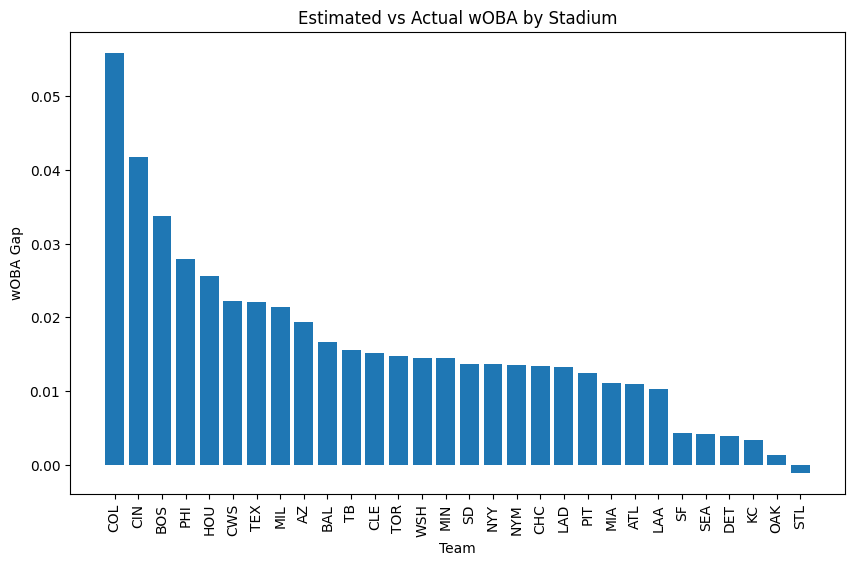

In [8]:
total_in_play_df = df[(df['description'] == 'hit_into_play') & (df['estimated_woba_using_speedangle'] != '<NA>')]
total_in_play_df['wOBA Gap'] = total_in_play_df['woba_value'] - total_in_play_df['estimated_woba_using_speedangle']
team_gaps = total_in_play_df.groupby('home_team')['wOBA Gap'].mean()
team_gaps = team_gaps.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(team_gaps.index, team_gaps.values)
plt.title('Estimated vs Actual wOBA by Stadium')
plt.xlabel('Team')
plt.ylabel('wOBA Gap')
plt.xticks(rotation=90)
plt.show()

- Histogram
- Launch speed (x) vs. distance (y)
- Separate based off Rockies at home

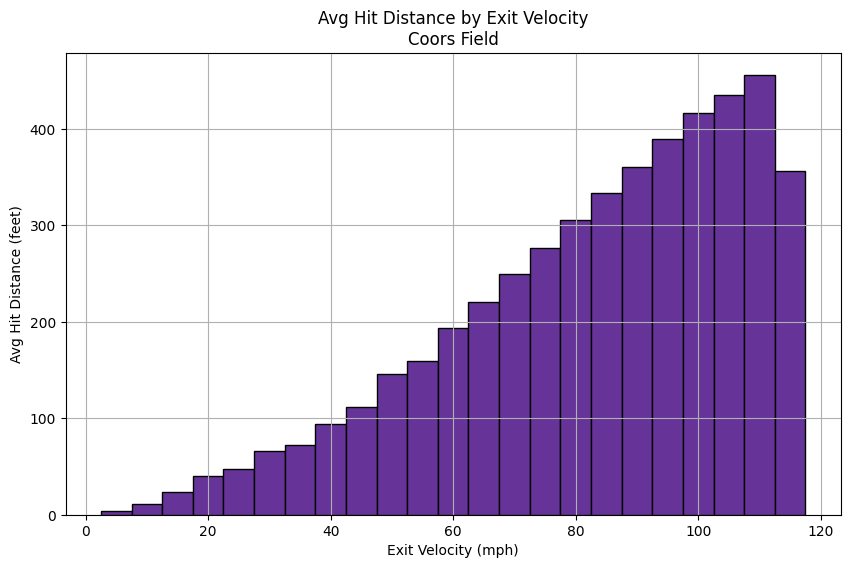

In [ ]:
step = 5
col_df['ev_bucket'] = np.floor(col_df['launch_speed'] / step) * step
dist = col_df.groupby('ev_bucket').agg(percentile_90 = ('hit_distance_sc',lambda x: x.quantile(0.9)))
#dist = dist.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(dist['percentile_90'].index, dist['percentile_90'].values, width=step, color='rebeccapurple', edgecolor='black')
plt.title('Avg Hit Distance by Exit Velocity\nCoors Field')
plt.xlabel('Exit Velocity (mph)')
plt.ylabel('Avg Hit Distance (feet)')
plt.grid(which='major')
plt.show()

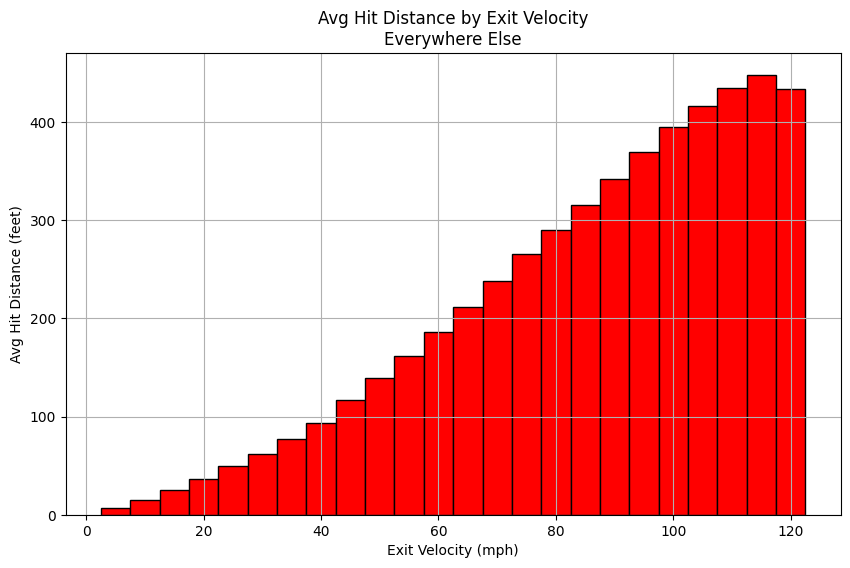

In [71]:
step = 5
in_play_df['ev_bucket'] = np.floor(in_play_df['launch_speed'] / step) * step
dist = in_play_df.groupby('ev_bucket').agg(percentile_90 = ('hit_distance_sc',lambda x: x.quantile(0.9)))
#dist = dist.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(dist['percentile_90'].index, dist['percentile_90'].values, width=step, color='red', edgecolor='black')
plt.title('Avg Hit Distance by Exit Velocity\nEverywhere Else')
plt.xlabel('Exit Velocity (mph)')
plt.ylabel('Avg Hit Distance (feet)')
plt.grid(which='major')
plt.show()

In [ ]:
step = 5
#min_la = 15
#max_la = 75
#min_ev = 75
#max_ev = 110
min_count = 10

col_df['ev_bucket'] = np.floor(col_df['launch_speed'] / step) * step
col_df['la_bucket'] = np.floor(col_df['launch_angle'] / step) * step
col_dist_full = col_df.groupby(['ev_bucket', 'la_bucket']).agg(
    avg_dist_col=('hit_distance_sc', 'mean'),
    count_col=('hit_distance_sc', 'count')
).reset_index()
#col_dist = col_dist_full[(col_dist_full.la_bucket >= min_la) & (col_dist_full.la_bucket <= max_la) & (col_dist_full.ev_bucket >= min_ev) & (col_dist_full.ev_bucket <= max_ev)]

in_play_df['ev_bucket'] = np.floor(in_play_df['launch_speed'] / step) * step
in_play_df['la_bucket'] = np.floor(in_play_df['launch_angle'] / step) * step
in_play_dist_full = in_play_df.groupby(['ev_bucket', 'la_bucket']).agg(
    avg_dist_tot=('hit_distance_sc', 'mean'),
    count_tot=('hit_distance_sc', 'count')
).reset_index()
#in_play_dist = in_play_dist_full[(in_play_dist_full.la_bucket >= min_la) & (in_play_dist_full.la_bucket <= max_la) & (in_play_dist_full.ev_bucket >= min_ev) & (in_play_dist_full.ev_bucket <= max_ev)]

dist = pd.merge(col_dist_full, in_play_dist_full, on=['ev_bucket', 'la_bucket'], how='inner')
dist['distance_gap'] = dist['avg_dist_col'] - dist['avg_dist_tot']
dist['ev_bucket'] = dist['ev_bucket'].astype(int)
dist['la_bucket'] = dist['la_bucket'].astype(int)

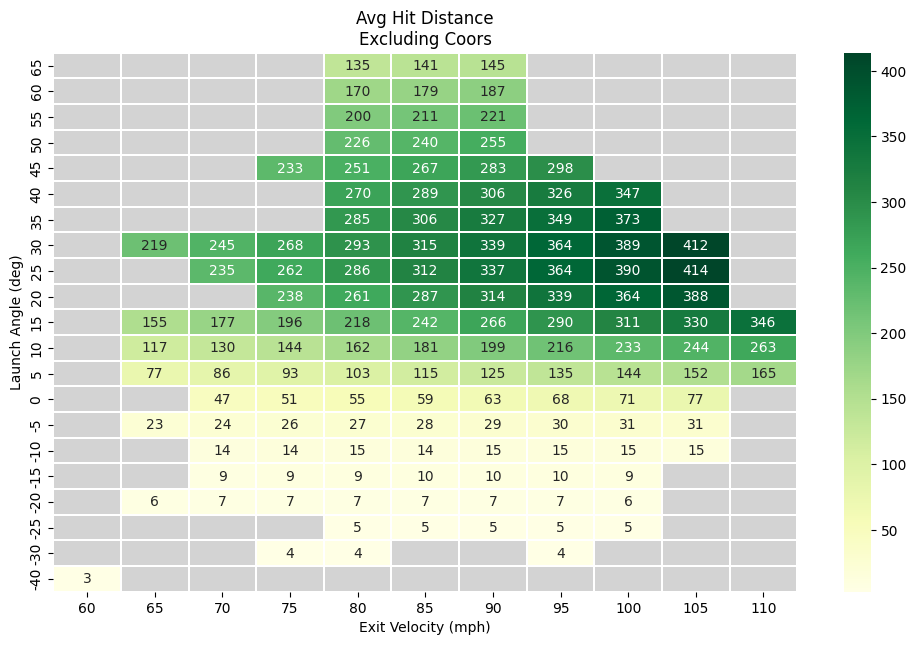

In [158]:
dist_pivot = dist[dist['count_col'] >= min_count].pivot(index='la_bucket', columns='ev_bucket', values='avg_dist_tot')
#dist_pivot[pd.isna(dist_pivot)] = 0.0
dist_pivot = dist_pivot.astype(float)


#limit = max(list(dist_pivot.max()) + list(dist_pivot.min()), key=abs)
#divnorm = colors.TwoSlopeNorm(vmin = -1 * limit, vcenter = 0, vmax = limit)

fig, ax = plt.subplots(figsize = (12, 7))
ax = sns.heatmap(dist_pivot, cmap = 'YlGn', linewidths = 0.01, annot = True, fmt = ".0f")
ax.set_facecolor('lightgray')
ax.invert_yaxis()
ax.set_title('Avg Hit Distance\nExcluding Coors')
ax.set_ylabel('Launch Angle (deg)')
ax.set_xlabel('Exit Velocity (mph)')
plt.show()

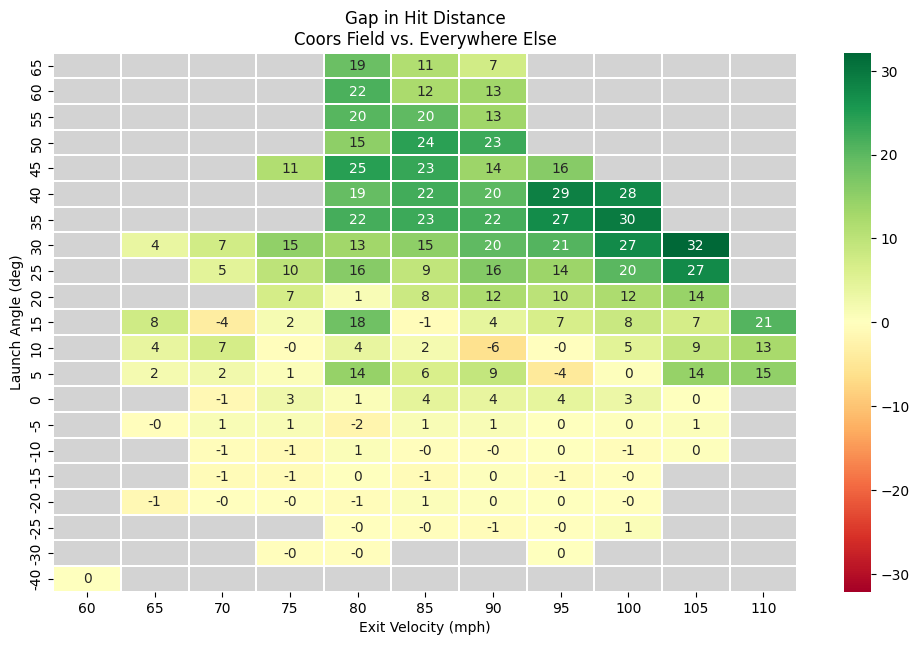

In [159]:
gap_pivot = dist[dist['count_col'] >= min_count].pivot(index='la_bucket', columns='ev_bucket', values='distance_gap')
#gap_pivot[pd.isna(gap_pivot)] = 0.0
gap_pivot = gap_pivot.astype(float)

limit = max(list(gap_pivot.max()) + list(gap_pivot.min()), key=abs)
divnorm = colors.TwoSlopeNorm(vmin = -1 * limit, vcenter = 0, vmax = limit)

fig, ax = plt.subplots(figsize = (12, 7))
ax = sns.heatmap(gap_pivot, cmap = 'RdYlGn', norm=divnorm, linewidths = 0.01, annot = True, fmt = ".0f")
ax.set_facecolor('lightgray')
ax.invert_yaxis()
ax.set_title('Gap in Hit Distance\nCoors Field vs. Everywhere Else')
ax.set_ylabel('Launch Angle (deg)')
ax.set_xlabel('Exit Velocity (mph)')
plt.show()